In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import random
#from fastai.vision import *
import fastai as f
from fastai.conv_learner import *
from fastai.dataset import *

In [3]:
#path to deepfashion dataset
PATH = Path('/home/abdalaziz/')
JPEGS = 'img'

In [4]:
f = (PATH/'list_bbox.txt').open().readlines()[2:]
f[0].replace('                        ',' ').split()

['img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', '072', '079', '232', '273']

In [5]:
bb = [row.replace('                        ',' ').split() for row in f]
for i,row in enumerate(bb):
    cat=row[0].split('/')[1].split('_')[-1]
    bb[i].extend([cat])


In [6]:

df = pd.DataFrame(bb,columns=['address','x_1','y_1','x_2','y_2','cat'])
df.x_1 = df.x_1.astype(int)
df.x_2 = df.x_2.astype(int)
df.y_1 = df.y_1.astype(int)
df.y_2 = df.y_2.astype(int)

In [7]:
df.cat.unique()
cat_order = df.cat.value_counts().sort_values(ascending=False)
cat_to_downsample = cat_order[cat_order> 45000].index.values

In [8]:
downsample = df[df.cat.isin(cat_to_downsample)].groupby(
    'cat').apply(
    lambda v : v.iloc[random.sample(range(len(v)),45000)]).reset_index(drop=True)

In [9]:
downsample

,address,x_1,y_1,x_2,y_2,cat
0,img/Abstract_Splatter_Bodycon_Dress/img_000000...,64,33,136,231,Dress
1,img/Lace-Paneled_Maxi_Dress/img_00000035.jpg,95,20,208,300,Dress
2,img/Abstract_Mosaic_Racerback_Dress/img_000000...,33,30,165,300,Dress
3,img/Zipped_Lace_Dress/img_00000077.jpg,47,55,136,239,Dress
4,img/Printed_Flutter-Sleeve_Dress/img_00000008.jpg,65,36,166,194,Dress
...,...,...,...,...,...,...
44995,img/Elephant_Print_Cami_Dress/img_00000007.jpg,38,53,168,292,Dress
44996,img/Glitter_Bodycon_Dress/img_00000089.jpg,124,34,203,187,Dress
44997,img/Crochet-Back_Cami_Dress/img_00000021.jpg,54,50,185,250,Dress
44998,img/Lace-Paneled_Fit_&_Flare_Dress/img_0000004...,4,42,220,288,Dress


In [10]:
df = pd.concat((df[~df.cat.isin(cat_to_downsample)],downsample)).sample(frac=1)
cat_to_merge = cat_order[cat_order<300].index.values


In [11]:
df['cat'] = df.cat.apply(lambda x : 'Other' if x in cat_to_merge else x)
cat_list = df.cat.unique()
cat_list.sort()

In [12]:
cat2ind = {cat:i for i,cat in enumerate(cat_list)}
ind2cat = {i:cat for i,cat in enumerate(cat_list)}
df.cat = df.cat.apply(lambda x : cat2ind[x])
df.cat.max()


33

In [13]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

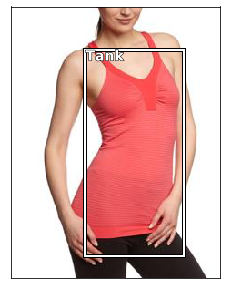

In [14]:
im_a = df[['y_1','x_1','y_2','x_2']].values

fig,ax = plt.subplots(figsize=(5,5))
num = 500
im = PIL.Image.open(PATH/df.address.iloc[num])
ax = show_img(im,ax=ax)
b = bb_hw(im_a[num])
draw_rect(ax, b)
draw_text(ax, b[:2], ind2cat[df.iloc[num]['cat']])

36748
136220
104062
100792
58298
84080


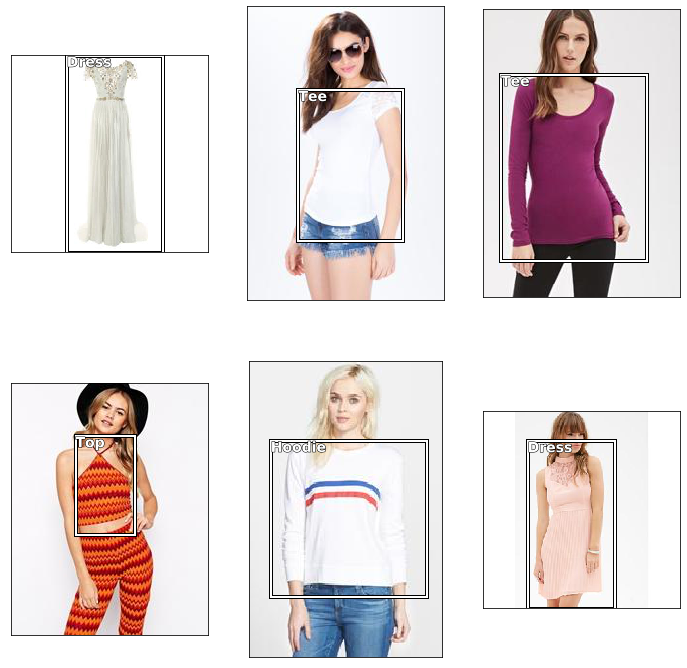

In [15]:
num_list = np.random.randint(0,len(df),6)
fig,axes = plt.subplots(2,3, figsize=(12,12))
for i,ax in enumerate(axes.flat):
    num = num_list[i]
    print(num)
    im = PIL.Image.open(PATH/df.address.iloc[num])
    ax = show_img(im,ax=ax)
    b = bb_hw(im_a[num])
    draw_rect(ax, b)
    draw_text(ax, b[:2], ind2cat[df.iloc[num]['cat']])

In [16]:
(PATH/'tmp').mkdir(exist_ok=True)

BB = PATH/'tmp/bb.csv'
df['bb']=df.y_1.astype(str)+' '+df.x_1.astype(str)+' '+df.y_2.astype(str)+' '+df.x_2.astype(str)
df['full_add'] = df.address.apply(lambda x : x[4:])
df[['full_add','bb']].to_csv(BB,index=False)

In [17]:
CSV = PATH/'tmp/cat.csv'
df[['full_add','cat']].to_csv(CSV,index=False)

In [18]:
CSV.open().readlines()[:4]


['full_add,cat\n',
 'Open-Back_Knit_Blouse/img_00000060.jpg,1\n',
 'Ombr&eacute;_Tank/img_00000048.jpg,30\n',
 'Chiffon-Paneled_High-Slit_Top/img_00000031.jpg,32\n']

In [19]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):

    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [20]:
f_model=resnet34
sz=224
bs=64
val_idxs = get_cv_idxs(len(df),val_pct=0.15)

In [21]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [22]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [23]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz) ,val_idxs=val_idxs)

In [24]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))
    

trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [25]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

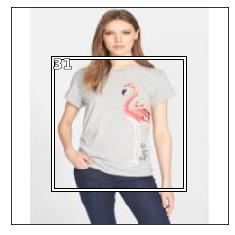

In [26]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx]))
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])


[ 36.  49. 145. 104.]
[ 31.  41. 173. 121.]
[ 41.  52. 137.  98.]
[ 41.  52. 137.  98.]
[ 38.  51. 142. 100.]
[ 41.  52. 137.  98.]
[ 44.  52. 137.  98.]
[ 35.  46. 153. 109.]
[ 34.  43. 164. 116.]


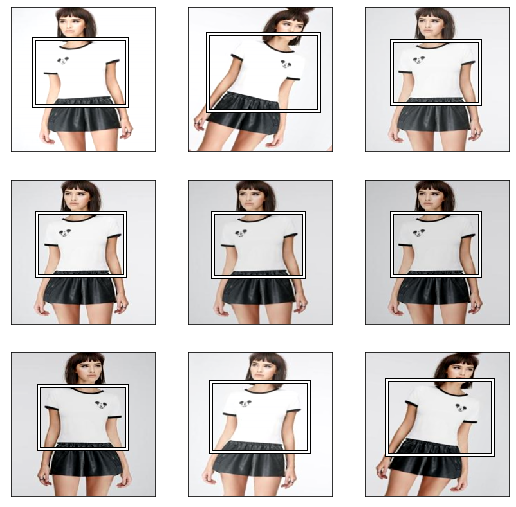

In [27]:
idx=4
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))

    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [28]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,2048),
    nn.ReLU(),
    nn.Linear(2048,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cat2ind)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/abdalaziz/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [30]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

  0%|          | 1/3481 [00:19<18:55:04, 19.57s/it, loss=166]

/data/anaconda/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 72%|███████▏  | 2501/3481 [13:19<04:26,  3.67it/s, loss=228]  

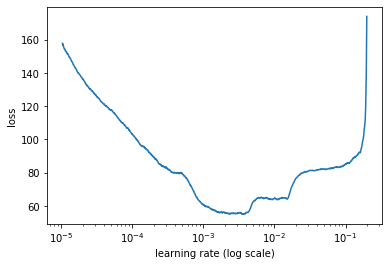

In [31]:
learn.lr_find()
learn.sched.plot()

In [33]:
lr = 3e-4
learn.metrics = []
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5),best_save_name='bestmodel')


  2%|▏         | 77/3481 [00:21<14:58,  3.79it/s, loss=50.9] 

KeyboardInterrupt: 

In [34]:
learn.save('model_1')

 76%|███████▌  | 2638/3481 [20:34<06:18,  2.22it/s, loss=190] 

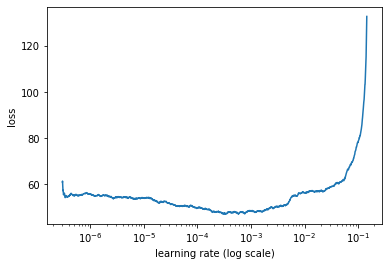

In [35]:
learn.freeze_to(-2)
lrs = np.array([lr/50, lr/5, lr])
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [37]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,10),best_save_name='bestmodel')

  1%|▏         | 50/3481 [00:23<25:50,  2.21it/s, loss=44.3] 

KeyboardInterrupt: 

In [39]:
#learn.load('bestmodel2')
y = learn.predict()
iter_x = iter(md.val_dl)
x,_ = next(iter_x)
x,_ = next(iter_x)
x,_ = next(iter_x)
x,_ = next(iter_x)

base = 64 *3

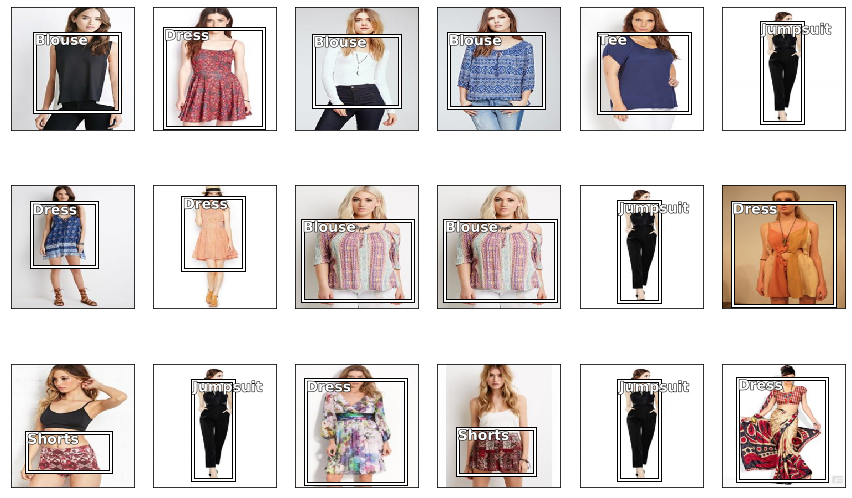

In [45]:
from scipy.special import expit
num_list = np.random.randint(0,63,19)
fig, axes = plt.subplots(3, 6, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    num = num_list[i]
    ima=md.val_ds.ds.denorm(to_np(x))[num]
    bb = expit(y[base+num][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[num+base][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], ind2cat[int(md2.classes[c])])
    #ax.title.set_text(ind2c)
plt.tight_layout()